In [1]:
from src.Data import Data
from src.Camera import Camera
from src.VisualOdometry import VisualOdometry
from src.data_association import *
from src.utils import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go   

In [2]:
data = Data()
camera = Camera()

In [3]:
index = 2
world_map = data.get_world_data()
measurement = data.get_measurements_data_points(index)
trajectory = data.get_trajectory_data()
pose_1 = v2T([0, 0, trajectory[index][0], 0, 0, 0])
camera.set_c_T_w(np.linalg.inv(pose_1))

In [4]:
matches = data_association_on_appearance(measurement, world_map)

image_points = matches['points_1'] # world map
world_points = matches['points_2'] # measurements

projected_points = []
for i in range(len(world_points)):
    world_point_hom = np.append(world_points[i], 1)
    world_point_in_camera = np.linalg.inv(camera.get_camera_transform()) @ world_point_hom
    world_point_in_camera = world_point_in_camera[:3] / world_point_in_camera[3]
    
    is_inside, projected_point = camera.project_point(world_point_in_camera)
    if is_inside: projected_points.append(projected_point)

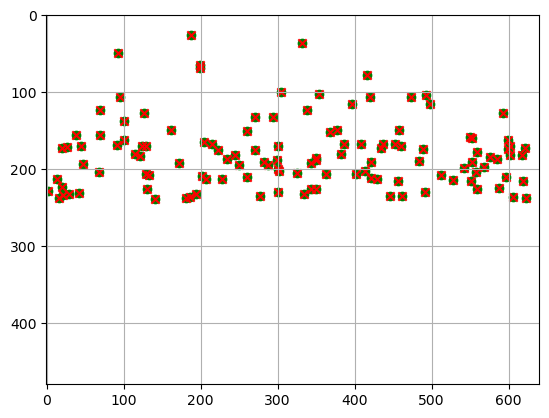

In [5]:
fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='green', marker='o')
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='red', marker='x')
plt.grid()
plt.show()

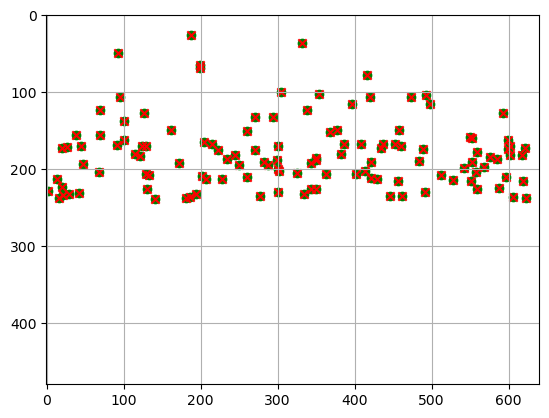

In [6]:
world_points_in_camera = []
for i in range(len(world_points)):
    world_point_hom = np.append(world_points[i], 1)
    world_point_in_camera = np.linalg.inv(camera.get_camera_transform()) @ world_point_hom
    world_point_in_camera = world_point_in_camera[:3] / world_point_in_camera[3]
    world_points_in_camera.append(world_point_in_camera)


projected_points = camera.project_points(world_points_in_camera)
projected_points = {'position':projected_points, 'appearance':world_map['appearance']}
matches = data_association_on_distance(measurement, projected_points)

image_points = matches['points_1'] # world map
projected_points = matches['points_2'] # measurements

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='green', marker='o')
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='red', marker='x')
plt.grid()
plt.show()


In [7]:
import pandas as pd
df = pd.DataFrame(matches)  
df

,points_1,points_2
0,"[300.051, 199.734]","[300.0505936224437, 199.73337753558624]"
1,"[558.968, 178.482]","[558.9676767952408, 178.48254219481248]"
2,"[492.844, 103.408]","[492.84428246013664, 103.40774487471526]"
3,"[44.5461, 169.677]","[44.54632497629274, 169.67691569407674]"
4,"[304.115, 99.833]","[304.115220559999, 99.83309865843029]"
...,...,...
118,"[260.672, 209.918]","[260.6724704542493, 209.91776895198845]"
119,"[604.982, 235.883]","[604.9818816103891, 235.88301791673805]"
120,"[299.616, 188.028]","[299.6161395317674, 188.0285284067467]"
121,"[343.475, 192.084]","[343.47472924187724, 192.0839018639947]"


In [8]:
vo = VisualOdometry()

vo.initialize()

In [9]:
pose_0 = vo.get_trajectory()[0]
pose_1 = vo.get_trajectory()[1]

world_points = vo.get_map()['position']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [10]:
trajectory = data.get_trajectory_data()
triangulated_points = {'position':[], 'appearance':[]}
triangulations = []

pose_0 = vo.get_trajectory()[0]
pose_1 = vo.get_trajectory()[1]

measurement_0 = data.get_measurements_data_points(0)
measurement_1 = data.get_measurements_data_points(1)
matches = data_association_on_appearance(measurement_0, measurement_1)
points_0 = np.array(matches['points_1'])
points_1 = np.array(matches['points_2'])
points_3D = vo.triangulate_points(points_0, points_1, pose_0, pose_1)
map = {'position':points_3D, 'appearance':matches['appearance']}

triangulations.append(map)
for i in range(len(map['position'])):
    if map['appearance'][i] not in triangulated_points['appearance']:
        triangulated_points['position'].append(map['position'][i])
        triangulated_points['appearance'].append(map['appearance'][i])

for i in range(1,15):    
    print('Frame: ', i)
    vo.update(i)
    
    pose_i = vo.get_trajectory()[i]
    measurement_i = data.get_measurements_data_points(i)    
    
    matches = data_association_on_appearance(measurement_0, measurement_i)
    points_0 = np.array(matches['points_1'])
    points_1 = np.array(matches['points_2'])
    print('Number of matches: ', len(points_0))

    points_3D = vo.triangulate_points(points_0, points_1, pose_0, pose_i)
    print('Number of triangulated points: ', len(points_3D))
    map = {'position':points_3D, 'appearance':matches['appearance']}

    new_map = {'position':[], 'appearance':[]}  
    for i in range(len(map['position'])):
        if map['appearance'][i] not in triangulated_points['appearance']:
            new_map['position'].append(map['position'][i])
            new_map['appearance'].append(map['appearance'][i])

    triangulated_points['position'] += new_map['position']
    triangulated_points['appearance'] += new_map['appearance']
    triangulations.append(new_map)

    pose_0 = pose_i
    measurement_0 = measurement_i

    print()

Frame:  1
Number of matches:  115
Number of triangulated points:  115

Frame:  2
Number of matches:  117
Number of triangulated points:  117

Frame:  3
Number of matches:  118
Number of triangulated points:  118

Frame:  4
Number of matches:  104
Number of triangulated points:  104

Frame:  5
Number of matches:  96
Number of triangulated points:  96

Frame:  6
Number of matches:  96
Number of triangulated points:  96

Frame:  7
Number of matches:  97
Number of triangulated points:  97

Frame:  8
Number of matches:  90
Number of triangulated points:  90

Frame:  9
Number of matches:  91
Number of triangulated points:  91

Frame:  10
Number of matches:  92
Number of triangulated points:  92

Frame:  11
Number of matches:  98
Number of triangulated points:  98

Frame:  12
Number of matches:  106
Number of triangulated points:  106

Frame:  13
Number of matches:  100
Number of triangulated points:  100

Frame:  14
Number of matches:  98
Number of triangulated points:  98



In [11]:
print('Number of triangulated points: ', len(triangulated_points['position']))

fig = go.Figure()

x_coords = [point[0] for point in triangulated_points['position']]  
y_coords = [point[1] for point in triangulated_points['position']]
z_coords = [point[2] for point in triangulated_points['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=3.5)))

first_triangulation = triangulations[0]
print('Number of points in first triangulation: ', len(first_triangulation['position']))
x_coords = [point[0] for point in first_triangulation['position']]
y_coords = [point[1] for point in first_triangulation['position']]
z_coords = [point[2] for point in first_triangulation['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='yellow')))

last_triangulation = triangulations[-1]
print('Number of points in last triangulation: ', len(last_triangulation['position']))
x_coords = [point[0] for point in last_triangulation['position']]
y_coords = [point[1] for point in last_triangulation['position']]
z_coords = [point[2] for point in last_triangulation['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))

for pose in vo.get_trajectory():
    t = pose[:3, 3]
    fig.add_trace(go.Scatter3d(x=[t[0]], y=[t[1]], z=[t[2]], mode='markers', marker=dict(size=2, color='green')))
fig.show()

Number of triangulated points:  212
Number of points in first triangulation:  115
Number of points in last triangulation:  6


In [12]:
index = 18

pose_0 = vo.get_trajectory()[index]
pose_1 = vo.get_trajectory()[index+1]
print('Pose_0: \n', np.round(pose_0, 2))
print('Pose_1: \n', np.round(pose_1, 2))

gt_pose_0 = data.get_trajectory_data()[index]
gt_pose_0 = v2T([gt_pose_0[0], gt_pose_0[1], 0, 0, 0, gt_pose_0[2]])

gt_pose_1 = data.get_trajectory_data()[index+1]
gt_pose_1 = v2T([gt_pose_1[0], gt_pose_1[1], 0, 0, 0, gt_pose_1[2]])

print('GT Pose_0: \n', np.round(gt_pose_0, 2)) 
print('GT Pose_1: \n', np.round(gt_pose_1, 2))

image_points_0 = data.get_measurements_data_points(index)
image_points_1 = data.get_measurements_data_points(index+1)

matches = data_association_on_appearance(image_points_0, image_points_1)
image_points_0 = np.array(matches['points_1'])
image_points_1 = np.array(matches['points_2'])
print('Number of matches: ', len(image_points_0))

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points_0], [point[1] for point in image_points_0], color='green', marker='o')
ax.scatter([point[0] for point in image_points_1], [point[1] for point in image_points_1], color='red', marker='o')

for i in range(len(image_points_0)):
    x = [image_points_0[i][0], image_points_1[i][0]]
    y = [image_points_0[i][1], image_points_1[i][1]]
    ax.plot(x, y, color='blue')
plt.grid()
plt.show()

gt_world_data = data.get_world_data()
matches = data_association_on_appearance(triangulations[index], gt_world_data)
triangulated_points = matches['points_1']
gt_world_points = matches['points_2']

triangulated_points_hom = [np.append(point, 1) for point in triangulated_points]
triangulated_points_world = camera.get_camera_transform() @ np.array(triangulated_points_hom).T
triangulated_points_world = triangulated_points_world.T

fig = go.Figure()
scale = 0.2056
x_coords = [point[0]*scale for point in triangulated_points_world]  
y_coords = [point[1]*scale for point in triangulated_points_world]
z_coords = [point[2]*scale for point in triangulated_points_world]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='blue')))

x_coords_gt = [point[0] for point in gt_world_points]
y_coords_gt = [point[1] for point in gt_world_points]
z_coords_gt = [point[2] for point in gt_world_points]
fig.add_trace(go.Scatter3d(x=x_coords_gt, y=y_coords_gt, z=z_coords_gt, mode='markers', marker=dict(size=2, color='red')))

fig.show()

IndexError: list index out of range

In [ ]:
gt_world_data = data.get_world_data()

matches = data_association_on_appearance(triangulated_points, gt_world_data)
gt_world_points = matches['points_2']

for i in range(len(matches['points_1'])):
    point_1 = matches['points_1'][i]
    point_2 = matches['points_2'][i]

    point_1 = camera.get_camera_transform() @ np.append(point_1, 1)
    point_1 = point_1[:3] / point_1[3]

    distance = np.linalg.norm(point_1 - point_2)
    print(f'Distance between point {i}: {np.round(distance, 2)}')


triangulated_points_hom = [np.append(point, 1) for point in triangulated_points['position']]
triangulated_points_world = camera.get_camera_transform() @ np.array(triangulated_points_hom).T


x_coords = [point[0] for point in triangulated_points_world.T]  
y_coords = [point[1] for point in triangulated_points_world.T]
z_coords = [point[2] for point in triangulated_points_world.T]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=4)))

x_coords_gt = [point[0] for point in gt_world_points]
y_coords_gt = [point[1] for point in gt_world_points]
z_coords_gt = [point[2] for point in gt_world_points]

fig.add_trace(go.Scatter3d(x=x_coords_gt, y=y_coords_gt, z=z_coords_gt, mode='markers', marker=dict(size=2, color='red')))

fig.show()

TypeError: list indices must be integers or slices, not str

In [ ]:
# def normalize_point(point, K):
#     return np.linalg.inv(K) @ np.append(point, 1)

# def triangulate_point(point_1, point_2, P1, P2):

#     A = np.zeros((4, 4))
    
#     A[0] = point_1[1] * P1[2] - P1[1]
#     A[1] = P1[0] - point_1[0] * P1[2]
#     A[2] = point_2[1] * P2[2] - P2[1]
#     A[3] = P2[0] - point_2[0] * P2[2]

#     _, _, V = np.linalg.svd(A)
#     point = V[-1]
    
#     return point



# def triangulate_points(matches, w_T_c1, w_T_c2, K):
#     c1_T_c2 = np.linalg.inv(w_T_c1) @ w_T_c2

#     P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
#     P2 = K @ c1_T_c2[:3]

#     image_points_1 = matches['points_1']
#     image_points_2 = matches['points_2']

#     points_4D = []
#     for i in range(len(image_points_1)):
#         image_point_1 = image_points_1[i]
#         image_point_2 = image_points_2[i]

#         norm_image_point_1 = normalize_point(image_point_1, K)
#         norm_image_point_2 = normalize_point(image_point_2, K)

#         point_4D = triangulate_point(norm_image_point_1, norm_image_point_2, P1, P2)
#         points_4D.append(point_4D)

#     points_4D = np.array(points_4D)
#     points_4D = w_T_c1 @ points_4D.T
#     points_3D = points_4D[:3] / points_4D[3]
#     print(points_3D.T)
#     return points_3D.T

In [ ]:
def triangulate_points(points_0, points_1, w_T_c0, w_T_c1):

    K = camera.get_camera_matrix()

    c1_T_c0 = np.linalg.inv(w_T_c1) @ w_T_c0
    c1_R_c0 = c1_T_c0[:3, :3]

    c1_t_c0 = c1_T_c0[:3, 3]

    H_0 = np.hstack((np.eye(3), np.zeros((3, 1))))
    H_1 = np.hstack((c1_R_c0, c1_t_c0.reshape(3, 1)))
    
    P_0_ = K @ H_0
    P_1_ = K @ H_1

    print(np.round(P_0_, 3))
    print(np.round(P_1_, 3))

    E, _ = cv2.findEssentialMat(points_0, points_1, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, points_0, points_1, K)

    P_0 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P_1 = K @ np.hstack((R, t*0.20))

    print(np.round(Rt2T(R, t), 2))
    print(np.round(P_0, 3))
    print(np.round(P_1, 3))

    T = Rt2T(w_T_c0[:3, :3].T, w_T_c0[:3, 3])  

    points_4D = cv2.triangulatePoints(P_0, P_1, points_0.T, points_1.T)
    points_4D = T @ points_4D
    points_3D = points_4D[:3] / points_4D[3]

    points_4D_ = cv2.triangulatePoints(P_0, P_1, points_0.T, points_1.T)
    points_4D_ = w_T_c0 @ points_4D_
    points_3D_ = points_4D_[:3] / points_4D_[3]


    return points_3D.T, points_3D_.T

Pose 0:
[[ 0.37  0.    0.93  0.54]
 [ 0.    1.    0.    0.  ]
 [-0.93  0.    0.37  4.04]
 [ 0.    0.    0.    1.  ]]
Pose 1:
[[ 0.18  0.    0.98  0.7 ]
 [ 0.    1.    0.    0.  ]
 [-0.98  0.    0.18  4.09]
 [ 0.    0.    0.    1.  ]]


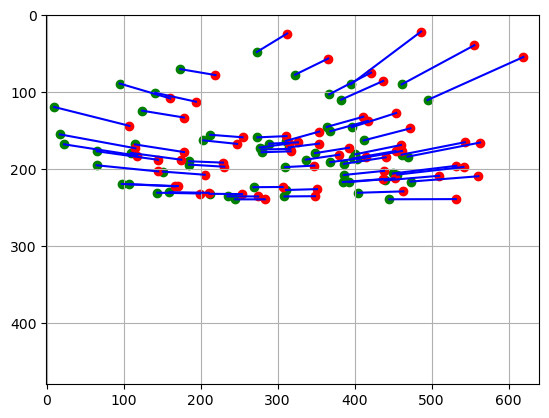

[[180.   0. 320.   0.]
 [  0. 180. 240.   0.]
 [  0.   0.   1.   0.]]
[[ 2.40006e+02  0.00000e+00  2.77844e+02 -5.15680e+01]
 [ 4.76970e+01  1.80000e+02  2.35213e+02 -4.10000e+01]
 [ 1.99000e-01  0.00000e+00  9.80000e-01 -1.71000e-01]]
[[ 0.98 -0.    0.2   0.13]
 [ 0.    1.   -0.    0.  ]
 [-0.2   0.    0.98 -0.99]
 [ 0.    0.    0.    1.  ]]
[[180.   0. 320.   0.]
 [  0. 180. 240.   0.]
 [  0.   0.   1.   0.]]
[[ 1.12788e+02  1.10000e-02  3.49398e+02 -5.89520e+01]
 [-4.77120e+01  1.80009e+02  2.35203e+02 -4.75820e+01]
 [-1.99000e-01  0.00000e+00  9.80000e-01 -1.98000e-01]]


In [ ]:
index = 22

trajectory = data.get_trajectory_data()

image_points_0 = data.get_measurements_data_points(index)
pose_0 = v2T(np.array([trajectory[index][1], 0, trajectory[index][0], 0, trajectory[index][2], 0]))

image_points_1 = data.get_measurements_data_points(index+1)
pose_1 = v2T(np.array([trajectory[index+1][1], 0, trajectory[index+1][0], 0, trajectory[index+1][2], 0]))

print(f'Pose 0:\n{np.round(pose_0, 2)}')
print(f'Pose 1:\n{np.round(pose_1, 2)}')

matches = data_association_on_appearance(image_points_0, image_points_1)
image_points_0 = np.array(matches['points_1'])
image_points_1 = np.array(matches['points_2'])

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points_0], [point[1] for point in image_points_0], color='green', marker='o')
ax.scatter([point[0] for point in image_points_1], [point[1] for point in image_points_1], color='red', marker='o')

for i in range(len(image_points_0)):
    x = [image_points_0[i][0], image_points_1[i][0]]
    y = [image_points_0[i][1], image_points_1[i][1]]
    ax.plot(x, y, color='blue')
plt.grid()
plt.show()

points_3D, points_3D_ = triangulate_points(image_points_0, image_points_1, pose_0, pose_1)
triangulated_points = {'position':points_3D, 'appearance':matches['appearance']}
triangulated_points_ = {'position':points_3D_, 'appearance':matches['appearance']}

gt_world_data = data.get_world_data()
matches = data_association_on_appearance(triangulated_points, gt_world_data)
triangulated_points = matches['points_1']
gt_world_points = matches['points_2']

matches_ = data_association_on_appearance(triangulated_points_, gt_world_data)
triangulated_points_ = matches_['points_1']


triangulated_points_hom = [np.append(point, 1) for point in triangulated_points]
triangulated_points_world = camera.get_camera_transform() @ np.array(triangulated_points_hom).T
triangulated_points_world = triangulated_points_world.T

triangulated_points_hom_ = [np.append(point, 1) for point in triangulated_points_]
triangulated_points_world_ = camera.get_camera_transform() @ np.array(triangulated_points_hom_).T
triangulated_points_world_ = triangulated_points_world_.T


fig = go.Figure()
x_coords = [point[0] for point in triangulated_points_world]  
y_coords = [point[1] for point in triangulated_points_world]
z_coords = [point[2] for point in triangulated_points_world]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=3, color='blue')))

x_coords = [point[0] for point in triangulated_points_world_]  
y_coords = [point[1] for point in triangulated_points_world_]
z_coords = [point[2] for point in triangulated_points_world_]
#fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='orange')))

x_coords_gt = [point[0] for point in gt_world_points]
y_coords_gt = [point[1] for point in gt_world_points]
z_coords_gt = [point[2] for point in gt_world_points]
fig.add_trace(go.Scatter3d(x=x_coords_gt, y=y_coords_gt, z=z_coords_gt, mode='markers', marker=dict(size=2, color='red')))

fig.show()

In [ ]:
NUM_FRAMES = 30
for i in range(1,NUM_FRAMES):
    print(f'i: {i}')
    vo.update(i)

i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
total_error: 26.637074424714953, dx: 8.911732472837336
total_error: 74.20351299275893, dx: 2.4316446486186107
total_error: 62.43610052776444, dx: 0.34612145196547645
total_error: 63.03420913929841, dx: 0.3274633098122646
total_error: 60.52258635808123, dx: 0.27593614693371693
total_error: 60.03976181224121, dx: 0.2663327089693489
total_error: 57.97544505219532, dx: 0.256315883191595
total_error: 57.87401520470101, dx: 0.2319165274778677
total_error: 56.07260680729735, dx: 0.22396215480356008
total_error: 54.370985695556676, dx: 0.17473422270188788
total_error: 53.00771139047145, dx: 0.16993793221451695
total_error: 54.993429668964495, dx: 0.16530123766858995
total_error: 53.61747995542998, dx: 0.13152412912991274
total_error: 52.48876070092564, dx: 0.11992839485774007
total_error: 51.456601660238235, dx: 0.1175817227785701
total_error: 52.68004971849823, dx: 0.11529104242928778
total_erro